### Finite difference methods (FDM) for the Black-Scholes PDE.

#### 1. Black-Scholes PDE

We begin with the Black-Scholes PDE for the price $V(S, t)$ of a European option:

$$\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0$$

This is a parabolic PDE, similar to the heat equation but with non-constant coefficients. 

One can transform this equation by a simple change of variables:

$$\tau = T - t$$
$$x = \ln(S)$$
$$u(x, \tau) = V(S, t) = V(e^x, T - \tau)$$

B-S equation transforms to:

$$\frac{\partial u}{\partial \tau} = \frac{1}{2} \sigma^2 \frac{\partial^2 u}{\partial x^2} + \left(r - \frac{1}{2} \sigma^2\right) \frac{\partial u}{\partial x} - r u$$

Which resembles the convection-diffusion-reaction form:

$$u_\tau = D u_{xx} + a u_x + b u$$

Where:
- $D = \frac{1}{2} \sigma^2$ (diffusion)
- $a = r - \frac{1}{2} \sigma^2$ (drift)
- $b = -r$ (decay)

If we eliminate the $u_x$ and $u$ terms, we get a pure heat equation:

$$u_\tau = D u_{xx}$$

This elimination can be done by choosing appropriate $\alpha$ and $\beta$ for the transformation below:

$$u(x, \tau) = e^{\alpha x + \beta \tau} w(x, \tau)$$

#### 2. Discretization of Black-Scholes PDE

In this project, we will solve Black-Scholes equation directly in terms of $S$.

Firstly, let us discretize the continuous domain:

- Price axis $S \in [0, S_{\text{max}}]$ is divided into $M$ steps
- Time axis $t \in [0, T]$ is divided into $N$ steps

We define:
- $\Delta S = \frac{S_{\text{max}}}{M}$
- $\Delta t = \frac{T}{N}$

Now let:
- $V_i^n$ be the numerical approximation to $V(S_i, t_n)$

##### 2.1 Explicit method

When pricing European options, we iteratively move backwards in time: start from option price at maturity, which is known, and move backwards in time from maturity to present moment.

Introduce time to maturity:

$$\tau = T - t$$

B-S equation transforms to:

$$\frac{\partial V}{\partial \tau} = \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V$$

Replace partial derivatives with finite differences:

- partial time derivative (Forward in time (to maturity)):
$$\frac{\partial V}{\partial \tau} \approx \frac{V_i^{n+1} - V_i^n}{\Delta \tau}$$

- First spatial derivative (central in space):
$$\frac{\partial V}{\partial S} \approx \frac{V_{i+1}^n - V_{i-1}^n}{2 \Delta S}$$

- Second spatial derivative:
$$\frac{\partial^2 V}{\partial S^2} \approx \frac{V_{i+1}^n - 2 V_i^n + V_{i-1}^n}{\Delta S^2}$$

After rearanging terms and solving for $V_i^{n+1}$ we get:

$$V_i^{n+1} = a_i V_{i-1}^n + b_i V_i^n + c_i V_{i+1}^n$$

Where coefficients:
$$a_i = \frac{1}{2} \Delta \tau \left( \sigma^2 i^2 - r i \right)$$
$$b_i = 1 - \Delta \tau \left( \sigma^2 i^2 + r \right) $$
$$c_i = \frac{1}{2} \Delta \tau \left( \sigma^2 i^2 + r i \right)$$

Boundary conditions:

For a Call Option:
- As $S \to 0$, the call becomes worthless $V(0, t) = 0$
- As $S \to \infty$, the option behaves like $S - K e^{-r(T - t)}$

For a Put Option:
- As $S \to 0$, option behaves like $V(0, t) = K e^{-r(T - t)}$
- As $S \to \infty$, the put becomes worthless $V(S_{max}, t)=0$

Thus, by knowing the option price at time $t_n$ one can directly compute the option price at time $t_{n+1}$.

The explicit method requires a very small dt due to the CFL (Courant–Friedrichs–Lewy) condition.

$$\Delta \tau \leq \frac{1}{\sigma^2 M^2}$$

Properties:
- It is simple to implement
- Conditionally stable: requires small time steps to avoid instability
- Stability condition: $\Delta \tau \leq \frac{1}{\sigma^2 M^2}$

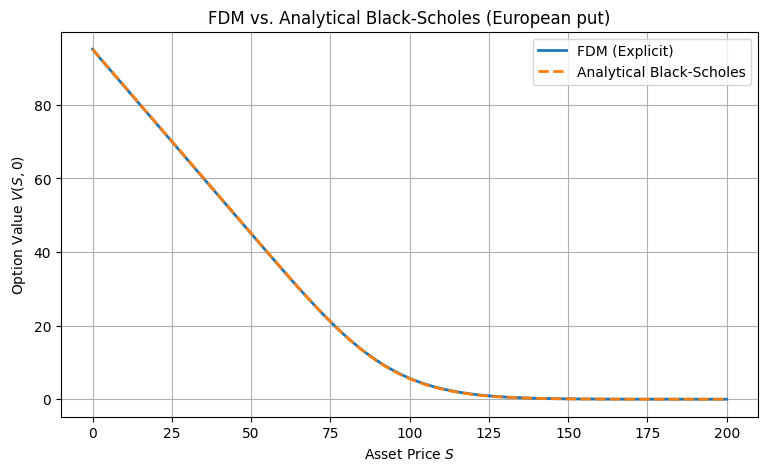

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
S_max = 200
X = 100
T = 1.0
r = 0.05
sigma = 0.2
call_or_put = "put"

M = 100
N = 1000

dS = S_max / M
dt = T / N
S = np.linspace(0, S_max, M, endpoint=True)

stability_condition = dt - 1 / (sigma ** 2 * M ** 2)

if stability_condition >= 0:
    print("Stability condition is not satisfied.")

if call_or_put == "call":
    V = np.maximum(S - X, 0)
elif call_or_put == "put":
    V = np.maximum(X - S, 0)
else:
    raise ValueError("Invalid option type. Use 'call' or 'put'.")

i = np.arange(1, M + 1)
a = 0.5 * dt * (sigma**2 * i**2 - r * i)
b = 1 - dt * (sigma**2 * i**2 + r)
c = 0.5 * dt * (sigma**2 * i**2 + r * i)

for n in range(N):
    V_old = V.copy()
    V[1:M-1] = a[1:M-1] * V_old[:M-2] + b[1:M-1] * V_old[1:M-1] + c[1:M-1] * V_old[2:]

    if call_or_put == "call":
        V[0] = 0
        V[M-1] = S_max - X * np.exp(-r * n * dt)
    elif call_or_put == "put":
        V[0] = X * np.exp(-r * n * dt)
        V[M-1] = 0
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

def black_scholes_european_options(S0, X, T, r, sigma, which="call"):

    d1 = (np.log(S0 / X + 1e-10) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if which == "call":
        price = S0 * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    elif which == "put":
        price = X * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    return price

V_exact = black_scholes_european_options(S, X, T, r, sigma, which=call_or_put)

plt.figure(figsize=(9, 5))
plt.plot(S, V, label='FDM (Explicit)', linewidth=2)
plt.plot(S, V_exact, '--', label='Analytical Black-Scholes', linewidth=2)
plt.xlabel('Asset Price $S$')
plt.ylabel('Option Value $V(S, 0)$')
plt.title(f'FDM vs. Analytical Black-Scholes (European {call_or_put})')
plt.legend()
plt.grid(True)
plt.show()

##### 2.2 Implicit method (Backward in Time (to maturity))

$$\frac{\partial V}{\partial \tau} = \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V$$

As in Explicit method, we replace partial derivatives with finite differences

But in this case, instead of forward difference, we use backward difference in time derivative:

- partial time derivative (Forward in time (to maturity)):
$$\frac{\partial V}{\partial \tau} \approx \frac{V_i^{n+1} - V_i^n}{\Delta \tau}$$

After rearanging terms, we get the following matrix equation, which has to be solved for $V_i^{n+1}$:

$$ -a_i V_{i-1}^{n+1} + (2 - b_i) V_i^{n+1} - c_i V_{i+1}^{n+1} = V_i^n$$

where coefficients have the same form as in Explicit method.

Properties:
- Requires solving a tridiagonal system at each time step
- Unconditionally stable
- Can be less accurate than Crank-Nicolson

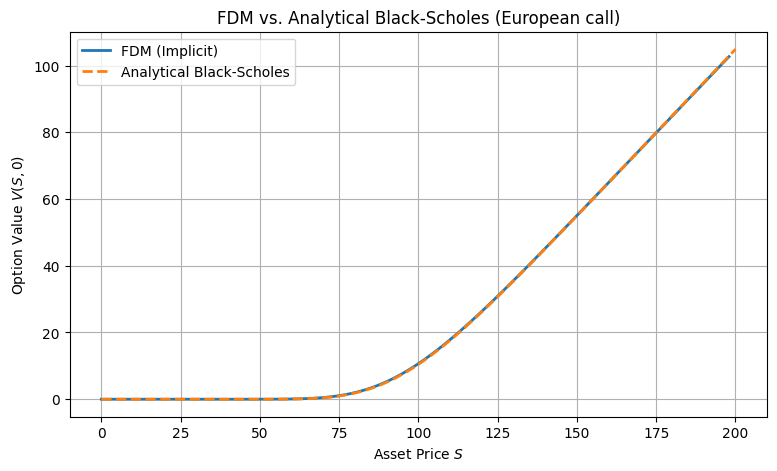

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.sparse import csc_matrix, lil_matrix
from scipy.sparse.linalg import spsolve

# Parameters
S_max = 200
X = 100
T = 1.0
r = 0.05
sigma = 0.2
call_or_put = "call"

M = 100
N = 100000

dS = S_max / M
dt = T / N
S = np.linspace(0, S_max, M, endpoint=True)

if call_or_put == "call":
    V = np.maximum(S - X, 0)
elif call_or_put == "put":
    V = np.maximum(X - S, 0)
else:
    raise ValueError("Invalid option type. Use 'call' or 'put'.")

i = np.arange(1, M + 1)
alpha = -0.5 * dt * (sigma**2 * i**2 - r * i)
beta = 1 + dt * (sigma**2 * i**2 + r)
gamma = -0.5 * dt * (sigma**2 * i**2 + r * i)

# Set up the banded matrix for efficient solving
lower = -alpha[1:]
main = beta
upper = -gamma[:-1]

A = lil_matrix((M, M))

for i in range(M):
    A[i, i] = beta[i]

for i in range(M-1):
    A[i, i+1] = gamma[i]
    A[i+1, i] = alpha[i + 1]

for n in range(N):
    
    V = spsolve(csc_matrix(A), V)

    # Boundary values
    if call_or_put == "call":
        V[0] = 0
        V[M-1] = S_max - X * np.exp(-r * n * dt)
    elif call_or_put == "put":
        V[0] = X * np.exp(-r * n * dt)
        V[M-1] = 0

def black_scholes_european_options(S0, X, T, r, sigma, which="call"):

    d1 = (np.log(S0 / X + 1e-10) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if which == "call":
        price = S0 * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    elif which == "put":
        price = X * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    return price

V_exact = black_scholes_european_options(S, X, T, r, sigma, which=call_or_put)

plt.figure(figsize=(9, 5))
plt.plot(S[:-1], V[:-1], label='FDM (Implicit)', linewidth=2)
plt.plot(S, V_exact, '--', label='Analytical Black-Scholes', linewidth=2)
plt.xlabel('Asset Price $S$')
plt.ylabel('Option Value $V(S, 0)$')
plt.title(f'FDM vs. Analytical Black-Scholes (European {call_or_put})')
plt.legend()
plt.grid(True)
plt.show()